In [1]:
# Import dependencies
import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import random

# Data Exploration:

In [2]:
# Save lockdown data to dataframe
lockdown_link = 'data/covid_lockdown.csv'
lockdown_data = pd.read_csv(lockdown_link)
lockdown_data.tail()

,Countries and territories,Place,Start date,End date,Level
115,United States,New York,3/20/2020,5/15/2020,State
116,United States,Oregon,3/24/2020,NaN,State
117,United States,Wisconsin,3/24/2020,NaN,State
118,Venezuela,NaN,3/17/2020,5/13/2020,National
119,Zimbabwe,NaN,3/30/2020,5/2/2020,National


In [3]:
# To make calculations easier, replace any TBD or NaN in 'End date' with arbitrary end date: 6/21/2020.
today = "6/21/2020"

lockdown_data['End date'] = lockdown_data['End date'].fillna(today)
lockdown_data['End date'] = lockdown_data['End date'].str.replace(pat = 'TBD', repl= today)

In [4]:
# Apply median incubation period (5 days) to lockdown start date in order to see effectiveness of lockdown
incubation_period = timedelta(days=5)
lockdown_data['Lock Effect Start'] = pd.to_datetime(lockdown_data['Start date'], format="%m/%d/%Y") + incubation_period
lockdown_data['Lock Effect End'] = pd.to_datetime(lockdown_data['End date'], format="%m/%d/%Y") + incubation_period
lockdown_data.tail()

,Countries and territories,Place,Start date,End date,Level,Lock Effect Start,Lock Effect End
115,United States,New York,3/20/2020,5/15/2020,State,2020-03-25,2020-05-20
116,United States,Oregon,3/24/2020,6/21/2020,State,2020-03-29,2020-06-26
117,United States,Wisconsin,3/24/2020,6/21/2020,State,2020-03-29,2020-06-26
118,Venezuela,NaN,3/17/2020,5/13/2020,National,2020-03-22,2020-05-18
119,Zimbabwe,NaN,3/30/2020,5/2/2020,National,2020-04-04,2020-05-07


In [5]:
# For countries that have more than one 'place', only keep the first entry
lock_data = lockdown_data.groupby("Countries and territories").first().reset_index()
lock_data.head()

,Countries and territories,Place,Start date,End date,Level,Lock Effect Start,Lock Effect End
0,Albania,None,3/13/2020,6/21/2020,National,2020-03-18,2020-06-26
1,Algeria,Algiers,3/23/2020,4/19/2020,City,2020-03-28,2020-04-24
2,Argentina,None,3/19/2020,5/10/2020,National,2020-03-24,2020-05-15
3,Armenia,None,3/24/2020,4/14/2020,National,2020-03-29,2020-04-19
4,Australia,None,3/23/2020,6/21/2020,National,2020-03-28,2020-06-26


In [6]:
# Make array of each country that experienced lockdown
lock_countries = lock_data['Countries and territories'].unique()
lock_countries

array(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bangladesh', 'Barbados', 'Belgium',
       'Bermuda', 'Bolivia', 'Botswana', 'Brazil', 'Chile', 'Colombia',
       'Costa Rica', 'Croatia', 'Cuba', 'Czech Republic', 'Denmark',
       'Dominican Republic', 'Ecuador', 'El Salvador', 'Eritrea', 'Fiji',
       'Finland', 'France', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Guernsey', 'Honduras', 'Hungary', 'India', 'Iraq', 'Ireland',
       'Israel', 'Italy', 'Jamaica', 'Jordan', 'Kosova', 'Kuwait',
       'Lebanon', 'Liberia', 'Libya', 'Lithuania', 'Luxembourg',
       'Madagascar', 'Malaysia', 'Mongolia', 'Montenegro', 'Morocco',
       'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nigeria',
       'Northern Cyprus', 'Norway', 'Oman', 'Pakistan', 'Panama',
       'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland',
       'Portugal', 'Qatar', 'Republic of the Congo', 'Romania', 'Russia',
       'Rwanda', 'Samoa', 'Sa

In [7]:
# Save Worldwide Covid data to dataframe
cov_link = 'data/world_covid.csv'
cov_data = pd.read_csv(cov_link)
cov_data["countriesAndTerritories"] = cov_data["countriesAndTerritories"].str.replace("_", " ")
cov_data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,04/05/2020,4,5,2020,235,13,Afghanistan,AF,AFG,37172386.0,Asia
1,03/05/2020,3,5,2020,134,4,Afghanistan,AF,AFG,37172386.0,Asia
2,02/05/2020,2,5,2020,164,4,Afghanistan,AF,AFG,37172386.0,Asia
3,01/05/2020,1,5,2020,222,4,Afghanistan,AF,AFG,37172386.0,Asia
4,30/04/2020,30,4,2020,122,0,Afghanistan,AF,AFG,37172386.0,Asia


In [8]:
# Make array of all countries and territories
all_countries = cov_data['countriesAndTerritories'].unique()
len(all_countries)

209

In [9]:
# Left merge dataframes keeping the world covid data in tact
combine = cov_data.merge(lock_data, how='inner', left_on='countriesAndTerritories', right_on='Countries and territories')

In [10]:
# Drop unneeded columns
combine = combine[['countriesAndTerritories', 'dateRep', 'day', 'month', 'cases', 'deaths', 'popData2018', 'Lock Effect Start', 'Lock Effect End']]

# Create boolean lockdown column and set to false when 'lockdown effective' is NaN
combine['Lockdown'] = pd.notnull(combine['Lock Effect Start'])

# Sets datatype of dates to datetime
combine['dateRep'] = pd.to_datetime(combine['dateRep'], format="%d/%m/%Y")


# Data Cleanup:

In [11]:
# Relabel Lockdown Values:
conditions = [
    combine['dateRep'] < combine['Lock Effect Start'],
    combine['dateRep'] > combine['Lock Effect End'],
    (combine['dateRep'] >= combine['Lock Effect Start']) | (combine['dateRep'] <= combine['Lock Effect End']),
]
result = [
    "Pre-Lockdown",
    "Post-Lockdown",
    "Lockdown",
]
combine['Lockdown'] = np.select(conditions, result, default="No Lockdown")
combine.tail(15)

,countriesAndTerritories,dateRep,day,month,cases,deaths,popData2018,Lock Effect Start,Lock Effect End,Lockdown
7676,Zimbabwe,2020-04-04,4,4,1,0,14439018.0,2020-04-04,2020-05-07,Lockdown
7677,Zimbabwe,2020-04-03,3,4,0,0,14439018.0,2020-04-04,2020-05-07,Pre-Lockdown
7678,Zimbabwe,2020-04-02,2,4,0,0,14439018.0,2020-04-04,2020-05-07,Pre-Lockdown
7679,Zimbabwe,2020-04-01,1,4,1,0,14439018.0,2020-04-04,2020-05-07,Pre-Lockdown
7680,Zimbabwe,2020-03-31,31,3,0,0,14439018.0,2020-04-04,2020-05-07,Pre-Lockdown
7681,Zimbabwe,2020-03-30,30,3,0,0,14439018.0,2020-04-04,2020-05-07,Pre-Lockdown
7682,Zimbabwe,2020-03-29,29,3,2,0,14439018.0,2020-04-04,2020-05-07,Pre-Lockdown
7683,Zimbabwe,2020-03-28,28,3,2,0,14439018.0,2020-04-04,2020-05-07,Pre-Lockdown
7684,Zimbabwe,2020-03-27,27,3,0,0,14439018.0,2020-04-04,2020-05-07,Pre-Lockdown
7685,Zimbabwe,2020-03-26,26,3,1,0,14439018.0,2020-04-04,2020-05-07,Pre-Lockdown


In [12]:
def test_pick(df):
    ret_list = []
    counter = 0
    num_samples = 14
    while counter < num_samples:
        country = random.choice(np.array(df["countriesAndTerritories"].unique()))
        if ((country not in ret_list) & 
            (df.loc[(df["countriesAndTerritories"] == country) & (df["Lockdown"] == "Lockdown"), "Lockdown"].count() >= 15) &
            (df.loc[(df["countriesAndTerritories"] == country) & (df["Lockdown"] == "Pre-Lockdown"), "Lockdown"].count() >= 15)):
            ret_list.append(country)
            counter += 1
    return ret_list
            

In [13]:
# Random Subset of countries over a set time period
test_list = test_pick(combine)
Test_limit = timedelta(days=14)     # upper time period to observe for each country
test_limit = timedelta(days=15)     # lower time period to observe for each country



In [14]:
# For more accurate comparisons of lockdown efficacy, selct data within the test range

test_data = combine[combine['countriesAndTerritories'].isin(test_list)].copy()    # make dataframe of only countries of interest
test_data['Pre-Lock'] = test_data['Lock Effect Start'].copy() - test_limit              # time period just before lockdown takes effect
test_data['Post-Lock'] = test_data['Lock Effect Start'].copy() + Test_limit             # time period just after lockdown takes effect
#print(test_data["Pre-Lock"][100:110])
# Get columns for loc statement
columns = list(test_data.columns)

# Get only data points within the lockdown period
condition = [
    (test_data['dateRep'] <= test_data['Pre-Lock']) | 
    (test_data['dateRep'] >= test_data['Post-Lock']) |
    (test_data["Lockdown"] == "Post-Lockdown")
]

result =[
    False
]

test_data['Keep'] = np.select(condition, result, default=True)
test_data = test_data.loc[test_data["Keep"] == True, columns].copy()
test_data.describe()

,dateRep,day,month,cases,deaths,popData2018,Lock Effect Start,Lock Effect End,Pre-Lock,Post-Lock
count,385,385.000000,385.000000,385.000000,385.000000,3.850000e+02,385,385,385,385
mean,2020-03-26 08:36:09.350649600,16.696104,3.311688,857.298701,50.467532,1.299922e+08,2020-03-26 15:53:45.974025984,2020-05-20 06:06:32.727272704,2020-03-11 15:53:45.974025728,2020-04-09 15:53:45.974025984
min,2020-03-05 00:00:00,1.000000,3.000000,0.000000,0.000000,6.077280e+05,2020-03-19 00:00:00,2020-04-16 00:00:00,2020-03-04 00:00:00,2020-04-02 00:00:00
25%,2020-03-19 00:00:00,9.000000,3.000000,52.000000,0.000000,9.630959e+06,2020-03-22 00:00:00,2020-05-03 00:00:00,2020-03-07 00:00:00,2020-04-05 00:00:00
50%,2020-03-26 00:00:00,18.000000,3.000000,156.000000,3.000000,2.499237e+07,2020-03-28 00:00:00,2020-05-16 00:00:00,2020-03-13 00:00:00,2020-04-11 00:00:00
75%,2020-04-02 00:00:00,25.000000,4.000000,590.000000,14.000000,6.698724e+07,2020-03-30 00:00:00,2020-05-30 00:00:00,2020-03-15 00:00:00,2020-04-13 00:00:00
max,2020-04-20 00:00:00,31.000000,4.000000,9222.000000,2004.000000,1.352617e+09,2020-04-07 00:00:00,2020-06-26 00:00:00,2020-03-23 00:00:00,2020-04-21 00:00:00
std,NaN,9.117212,0.463786,1693.151851,164.070693,3.442435e+08,NaN,NaN,NaN,NaN


In [15]:
# This loop adds the value 'date count' to compare date ranges of each country against each other
count = 1
test_data['Date Count'] = count
test_data.sort_values(by=['countriesAndTerritories', 'dateRep'], inplace=True)
test_data.reset_index(drop=True, inplace=True)
for x in range(1, len(test_data)):
    if ((test_data['countriesAndTerritories'][x] == test_data['countriesAndTerritories'][x -1]) &
        (test_data['Lockdown'][x] == test_data['Lockdown'][x -1])):
        count += 1
        test_data.loc[x, 'Date Count'] = count
    else:
        count = 1
        test_data.loc[x, 'Date Count'] = count
test_data.head(20)

,countriesAndTerritories,dateRep,day,month,cases,deaths,popData2018,Lock Effect Start,Lock Effect End,Lockdown,Pre-Lock,Post-Lock,Date Count
0,Australia,2020-03-14,14,3,41,0,24992369.0,2020-03-28,2020-06-26,Pre-Lockdown,2020-03-13,2020-04-11,1
1,Australia,2020-03-15,15,3,52,0,24992369.0,2020-03-28,2020-06-26,Pre-Lockdown,2020-03-13,2020-04-11,2
2,Australia,2020-03-16,16,3,49,2,24992369.0,2020-03-28,2020-06-26,Pre-Lockdown,2020-03-13,2020-04-11,3
3,Australia,2020-03-17,17,3,77,0,24992369.0,2020-03-28,2020-06-26,Pre-Lockdown,2020-03-13,2020-04-11,4
4,Australia,2020-03-18,18,3,79,0,24992369.0,2020-03-28,2020-06-26,Pre-Lockdown,2020-03-13,2020-04-11,5
5,Australia,2020-03-19,19,3,111,1,24992369.0,2020-03-28,2020-06-26,Pre-Lockdown,2020-03-13,2020-04-11,6
6,Australia,2020-03-20,20,3,144,0,24992369.0,2020-03-28,2020-06-26,Pre-Lockdown,2020-03-13,2020-04-11,7
7,Australia,2020-03-21,21,3,165,1,24992369.0,2020-03-28,2020-06-26,Pre-Lockdown,2020-03-13,2020-04-11,8
8,Australia,2020-03-22,22,3,224,0,24992369.0,2020-03-28,2020-06-26,Pre-Lockdown,2020-03-13,2020-04-11,9
9,Australia,2020-03-23,23,3,611,0,24992369.0,2020-03-28,2020-06-26,Pre-Lockdown,2020-03-13,2020-04-11,10


In [16]:
# Optimized method of creating date labels for test ranges (only for test ranges of exactly 14 days)
# num_countries = len(test_data["countriesAndTerritories"].unique())
# date_list = np.array(range(1,15))
# date_count = np.array([date_list for i in range(num_countries * 2)]).flatten()
# test_data.sort_values(by=['countriesAndTerritories', 'dateRep'], inplace=True)
# test_data.reset_index(drop=True, inplace=True)
# test_data["Date Count"] = date_count
# test_data.head()

# Data Analysis:

In [17]:
group_mean = test_data.groupby(['countriesAndTerritories', 'Lockdown'])[["cases", "deaths"]].mean()
group_mean

cases      deaths
countriesAndTerritories Lockdown                             
Australia               Lockdown       213.285714    2.785714
                        Pre-Lockdown   215.000000    0.714286
Chile                   Lockdown       274.214286    2.357143
                        Pre-Lockdown    44.428571    0.071429
France                  Lockdown      3694.714286  432.642857
                        Pre-Lockdown   857.071429   31.500000
Germany                 Lockdown      5088.357143  151.428571
                        Pre-Lockdown  2851.357143   17.714286
Greece                  Lockdown        75.928571    4.285714
                        Pre-Lockdown    54.214286    1.785714
India                   Lockdown       526.928571   17.714286
                        Pre-Lockdown    63.500000    1.642857
Iraq                    Lockdown        61.142857    2.857143
                        Pre-Lockdown    19.714286    1.500000
Israel                  Lockdown       361.500000    8.785714
                        Pre-Lockdown   525.642857    3.428571
Lithuania               Lockdown        42.928571    0.642857
                        Pre-Lockdown     5.222222    0.000000
Luxembourg              Lockdown       147.071429    1.642857
                        Pre-Lockdown    55.583333    0.666667
Netherlands             Lockdown       874.071429   90.214286
                        Pre-Lockdown   169.857143    5.428571
Philippines             Lockdown       203.428571   16.214286
                        Pre-Lockdown   138.714286    5.428571
Spain                   Lockdown      5945.642857  549.857143
                        Pre-Lockdown   787.642857   35.071429
United Arab Emirates    Lockdown       261.071429    1.428571
                        Pre-Lockdown    27.285714    0.142857

In [18]:
group_sum = test_data.groupby(['countriesAndTerritories', 'Lockdown'])[['cases', 'deaths']].sum()
group_sum

cases  deaths
countriesAndTerritories Lockdown                   
Australia               Lockdown       2986      39
                        Pre-Lockdown   3010      10
Chile                   Lockdown       3839      33
                        Pre-Lockdown    622       1
France                  Lockdown      51726    6057
                        Pre-Lockdown  11999     441
Germany                 Lockdown      71237    2120
                        Pre-Lockdown  39919     248
Greece                  Lockdown       1063      60
                        Pre-Lockdown    759      25
India                   Lockdown       7377     248
                        Pre-Lockdown    889      23
Iraq                    Lockdown        856      40
                        Pre-Lockdown    276      21
Israel                  Lockdown       5061     123
                        Pre-Lockdown   7359      48
Lithuania               Lockdown        601       9
                        Pre-Lockdown     47       0
Luxembourg              Lockdown       2059      23
                        Pre-Lockdown    667       8
Netherlands             Lockdown      12237    1263
                        Pre-Lockdown   2378      76
Philippines             Lockdown       2848     227
                        Pre-Lockdown   1942      76
Spain                   Lockdown      83239    7698
                        Pre-Lockdown  11027     491
United Arab Emirates    Lockdown       3655      20
                        Pre-Lockdown    382       2

Text(0.5, 1.0, 'Cases With and Without Lockdown Effect')

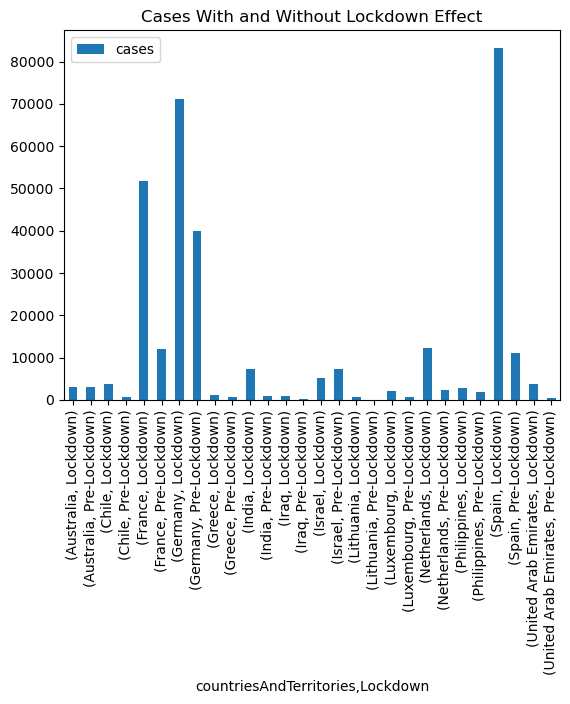

In [19]:
group_sum['cases'].plot.bar(legend=True)
plt.title('Cases With and Without Lockdown Effect')

Because of the exponential spread of the virus, it is difficult to tease out the trend of whether the lockdowns were effective  when looking only at the raw sum, even over a very similar period of time.

In [20]:
test_data[['cases', 'deaths']].describe()

,cases,deaths
count,385.000000,385.000000
mean,857.298701,50.467532
std,1693.151851,164.070693
min,0.000000,0.000000
25%,52.000000,0.000000
50%,156.000000,3.000000
75%,590.000000,14.000000
max,9222.000000,2004.000000


It is difficult to use any of the normal statistical metrics to gauge efficacy of the lockdowns without arranging the data a little better

## Using a log scale and a regression line, we can more easily track the acceleration of the exponential spread of the virus

In [21]:
def get_regress(x, y):
    slope, cept, r, p, se = stats.linregress(x, y)
    regress = slope * x + cept
    return regress, cept, slope

In [22]:
# Get totals of all deaths ani cases per day of selected timeframe
pre_lock = test_data[test_data['Lockdown'] == "Pre-Lockdown"].groupby(['Date Count'])[['cases','deaths']].sum()
pre_lock["deaths"] = np.where(pre_lock["deaths"] == 0, 1, pre_lock["deaths"])
lock = test_data[test_data['Lockdown'] == "Lockdown"].groupby(['Date Count'])[['cases','deaths']].sum()
date_list = np.array(test_data["Date Count"].unique())
# Scale the totals using a log10 scale to flatten out the exponential curve

log_pre_lock = np.log10(pre_lock)
log_lock = np.log10(lock)

# Grab regression values for plot
pre_case_reg, pre_case_int, pre_case_slope = get_regress(date_list, log_pre_lock["cases"])
pre_death_reg, pre_death_int, pre_death_slope = get_regress(date_list, log_pre_lock["deaths"])
lock_case_reg, lock_case_int, lock_case_slope = get_regress(date_list, log_lock["cases"])
lock_death_reg, lock_death_int, lock_death_slope = get_regress(date_list, log_lock["deaths"])

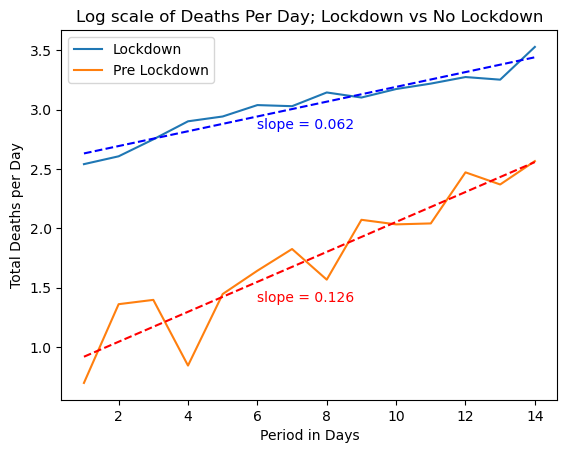

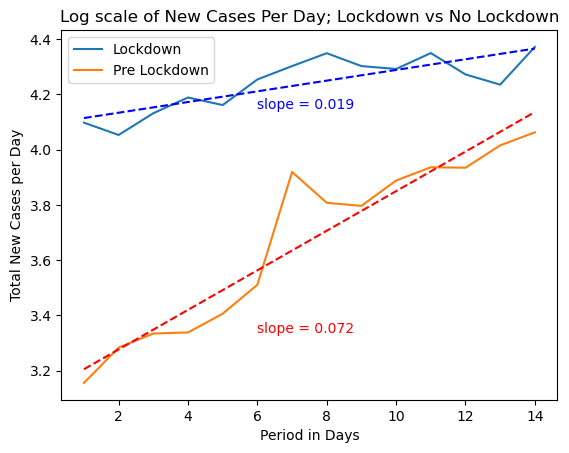

----------------------------------------------------------------------------------
 
Ratio of Case Slopes: Prelockdown vs Lockdown
The slope from cases before the lockdown is 3.7x greater than during the lockdown
 
----------------------------------------------------------------------------------
 
Ratio of Death Slopes: Prelockdown vs Lockdown
The slope from deaths before the lockdown is 2.02x greater than during the lockdown
 
----------------------------------------------------------------------------------


In [30]:
def pick_coords(y_vals):
    range_case = y_vals["cases"].quantile(q=0.2)
    range_death = y_vals["deaths"].quantile(q=.2)
    return (6, range_case), (6, range_death)

lock_coords_c, lock_coords_d = pick_coords(log_lock)
prelock_coords_c, prelock_coords_d = pick_coords(log_pre_lock)

plt.plot(log_lock['deaths'], label='Lockdown')
plt.plot(date_list, lock_death_reg, "b--")
plt.annotate(f"slope = {round(lock_death_slope, 3)}", lock_coords_d, color="b")
plt.plot(log_pre_lock['deaths'], label='Pre Lockdown')
plt.plot(date_list, pre_death_reg, "r--")
plt.annotate(f"slope = {round(pre_death_slope, 3)}", prelock_coords_d, color="r")
plt.title('Log scale of Deaths Per Day; Lockdown vs No Lockdown')
plt.ylabel('Total Deaths per Day')
plt.xlabel('Period in Days')
plt.legend()
plt.show()


plt.plot(log_lock['cases'], label='Lockdown')
plt.plot(date_list, lock_case_reg, "b--")
plt.annotate(f"slope = {round(lock_case_slope, 3)}", lock_coords_c, color="b")
plt.plot(log_pre_lock['cases'], label='Pre Lockdown')
plt.plot(date_list, pre_case_reg, "r--")
plt.annotate(f"slope = {round(pre_case_slope, 3)}", prelock_coords_c, color="r")
plt.title('Log scale of New Cases Per Day; Lockdown vs No Lockdown')
plt.ylabel('Total New Cases per Day')
plt.xlabel('Period in Days')
plt.legend()
plt.show()

print("----------------------------------------------------------------------------------")
print(" ")
print("Ratio of Case Slopes: Prelockdown vs Lockdown")
print(f"The slope from cases before the lockdown is {round(pre_case_slope/lock_case_slope, 2)}x greater than during the lockdown")
print(" ")
print("----------------------------------------------------------------------------------")
print(" ")
print("Ratio of Death Slopes: Prelockdown vs Lockdown")
print(f"The slope from deaths before the lockdown is {round(pre_death_slope/lock_death_slope, 2)}x greater than during the lockdown")
print(" ")
print("----------------------------------------------------------------------------------")

In [24]:
# Calculations to find the effecacy of the lockdown in case and death rates compared to estimates of the cases and deaths without it
lock_period = 14
deaths_prevented = ( sum([10**(pre_death_slope * (x+lock_period) + pre_death_int) for x in date_list]) - 
                     sum([10**(lock_death_slope * x + lock_death_int) for x in date_list])  )
cases_prevented = ( sum([10**(pre_case_slope * (x+lock_period) + pre_case_int) for x in date_list]) -
                    sum([10**(lock_case_slope * x + lock_case_int) for x in date_list])  )

print(f"The number of cases prevented from the lockdown was roughly {round(cases_prevented, 0)} cases for this subset and duration")
print(f"The number of deaths prevented from the lockdown was roughly {round(deaths_prevented, 0)} deaths for this subset and duration")

The number of cases prevented from the lockdown was roughly 566725.0 cases for this subset and duration
The number of deaths prevented from the lockdown was roughly 64122.0 deaths for this subset and duration


This graph makes it clear that even though the spread of the disease is still exponentially increasing, the slope of the lockdown period is much less steep than the slope of the period before lockdown. This indicates that the actual exponential rate of increase has gone down, even if the raw number of cases/deaths is still increasing over time. 

The reason the total number of cases/deaths between plotted groups don't have overlap is because the two groups being compared are really the same experimental group being observed at two points in time, 14 days before the lockdown effect can be seen and 14 days directly after that. The log scales normalizes the the exponential curves so that the slopes can be compared to see differences in rates of exponential growth rather than directly comparing the total cases and deaths per day.

When applying the regression equation for the lockdown and pre-lockdown periods, it is calculated that the implementation of the lockdown for a period of just 19 days (5 day incubation period for the virus during the initial lockdown period plus the period of 14 observed days of the observed lockdown effect) prevented hundreds of thousands of new covid cases within this test sample alone and prevented tens of thousands of deaths. If the lockdown procedures were to have occured sooner, these numbers would have been even more dramatically decreased as the effects of the exponential spread would have been cut off much sooner.

# Checking Subset Distribution vs Population Distribution
------------------------------------------------------------------

### Null Hypothesis:

    Checking to see if subset and population follow a normal distribution (null hypothesis accepted for normal distributions)

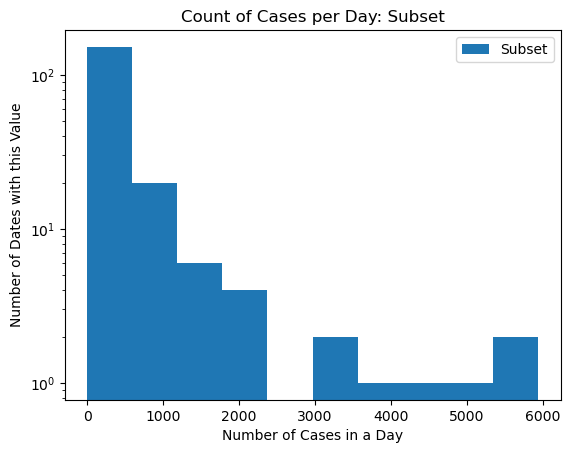

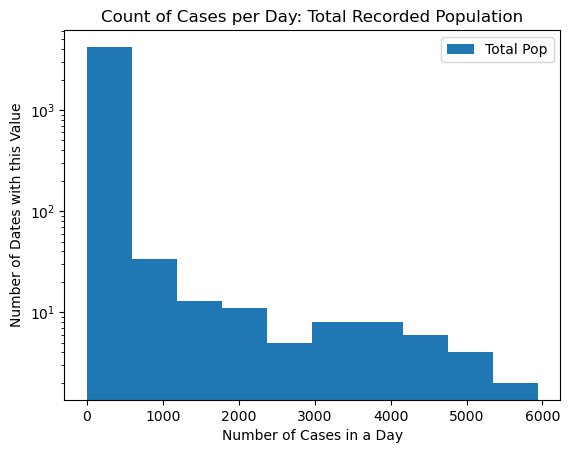

Subset:
DescribeResult(nobs=189, minmax=(0, 5940), mean=430.031746031746, variance=872699.2223910841, skewness=3.86254772035176, kurtosis=16.4056005348466)
Shapiro W: 0.4843357801437378
Shapiro p-value: 3.39713924264673e-23


Pre Lockdown:
DescribeResult(nobs=4297, minmax=(0, 5940), mean=60.779148242960204, variance=146245.61950923712, skewness=9.782584046641, kurtosis=106.61959764883254)
Shapiro W: 0.142791748046875
Shapiro p-value: 0.0


In [25]:
# Plots to show distribution of case rates before and during the lockdown period
plt.yscale("log")
plt.hist(test_data[test_data['Lockdown'] == "Pre-Lockdown"]['cases'], label='Subset')
plt.title('Count of Cases per Day: Subset')
plt.ylabel('Number of Dates with this Value')
plt.xlabel('Number of Cases in a Day')
plt.legend()
plt.show()

plt.yscale("log")
plt.hist(combine[combine['Lockdown'] == "Pre-Lockdown"]['cases'], label='Total Pop')
plt.title('Count of Cases per Day: Total Recorded Population')
plt.ylabel('Number of Dates with this Value')
plt.xlabel('Number of Cases in a Day')
plt.legend()
plt.show()

subset_shapiro = stats.shapiro(test_data[test_data['Lockdown'] == "Pre-Lockdown"]['cases'])
total_shapiro = stats.shapiro(combine[combine['Lockdown'] == "Pre-Lockdown"]['cases'])


print('Subset:')
print(stats.describe(test_data[test_data['Lockdown'] == "Pre-Lockdown"]['cases']))
print('Shapiro W: {}'.format(subset_shapiro[0]))
print('Shapiro p-value: {}'.format(subset_shapiro[1]))
print('\n')
print('Pre Lockdown:')
print(stats.describe(combine[combine['Lockdown'] == "Pre-Lockdown"]['cases']))
print('Shapiro W: {}'.format(total_shapiro[0]))
print('Shapiro p-value: {}'.format(total_shapiro[1]))


With p-values well below 5% and W scores far from 1, both datasets can reject the null hypothesis that this dataset is normally distributed, so a ttest cant be used for further comparison of values between datasets. This is to be expected as the spread of the virus seems to follow closer to an exponential distribution.

### Null Hypothesis:

    Checking to see if subset and population follow an exponential distribution (null hypothesis accepted for exponential distributions)

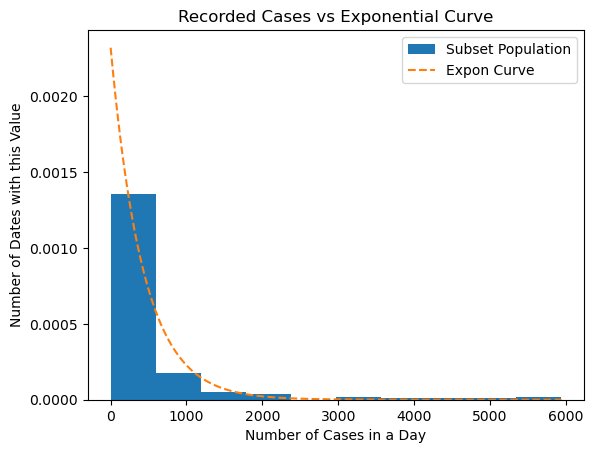

KstestResult(statistic=0.37030636215691204, pvalue=9.230248695686028e-24, statistic_location=114, statistic_sign=1)


In [32]:
cases_total = test_data[test_data['Lockdown'] == "Pre-Lockdown"]['cases']
num_cases = cases_total.count()
max_cases = cases_total.max()
params = stats.expon.fit(cases_total)
lock_cases_stats = stats.kstest(cases_total, "expon", args=params)

plt.hist(cases_total, label='Subset Population', density=True)
x=np.linspace(1,max_cases,num_cases).round(0)
y=stats.expon.pdf(x, loc=params[0], scale=params[1])
plt.plot(x, y, "--", label="Expon Curve")
plt.title('Recorded Cases vs Exponential Curve')
plt.ylabel('Number of Dates with this Value')
plt.xlabel('Number of Cases in a Day')
plt.legend()
plt.show()

print(lock_cases_stats)

The pvalue when comparing the sample to a true exponential curve is still incredibly low, so even though visually the distribution seems to correlate with an exponential distribution, the actual sample cases don't follow the curve well enough to be considered exponential and the null hypothesis that this is an exponential distribution is rejected.

## Median Ratios:

In [27]:
median_deaths = test_data['deaths'].median()
median_cases = test_data['cases'].median()
mean_pop = test_data['popData2018'].mean()
death_per_case = median_deaths / median_cases
cases_per_pop = median_cases / mean_pop
print('Median deaths per median positive cases: {}'.format(death_per_case))
print('Median positve cases per average population: {}'.format(cases_per_pop))

Median deaths per median positive cases: 0.019230769230769232
Median positve cases per average population: 1.2000721997243582e-06


# To summarize:
### Even if there was a slowdown in number of deaths per day by COVID-19, it wasn't enough to cause the raw rate of deaths to decrease over time. This means lockdowns alone aren't enough to stop the exponential nature of the spread of the virus, but when the curves are shown on a log scale, the differences in their slopes (case/death rates of countries going into lockdown vs the time period just before lockdown) indicates that lockdowns have a noticeable impact on the infection rate. To see the long-term effectiveness of the lockdowns, further measurements can be taken to compare the infection rate of those countries after re-opening their regions.

### This information could be useful to lawmakers when determining how long their lockdown measures should remain in effect and when exactly to implement them. From the data gathered so far, it can be safely concluded the lockdowns show a strong correlation with a slowed exponential rate of infection when compared against those same countries before they went into lockdown.